In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 1

setup_random_seed(RANDOM_SEED)

In [2]:
def sample_mixture_of_gaussians(normal_parameters, weights = None, size = 1000):
    weights = weights if weights is not None else np.ones(normal_parameters.shape[0], dtype=np.float64) / normal_parameters.shape[0]
    mixture_idx = np.random.choice(len(weights), size=size, replace=True, p=weights)
    return np.fromiter((stats.norm.rvs(*(normal_parameters[i])) for i in mixture_idx), dtype=np.float64)


def generate_data(size):
    df1 = pd.DataFrame({'value': np.random.normal(size = size)})
    df1['X1'] = 'A'
    df1['X2'] = 'X'

    df2 = pd.DataFrame({'value': np.random.exponential(scale=3.0, size = size)})
    df2['X1'] = 'A'
    df2['X2'] = 'Y'

    df3 = pd.DataFrame({'value': sample_mixture_of_gaussians(np.array([[-10, 1], [10, 1]]), size = size)})
    df3['X1'] = 'B'
    df3['X2'] = 'X'

    df4 = pd.DataFrame({'value': np.random.gamma(shape = 7.5, scale = 1.0, size = size)})
    df4['X1'] = 'B'
    df4['X2'] = 'Y'

    df = pd.concat([df1, df2, df3, df4])
    x, y = df[['X1', 'X2']], df[['value']]
    return df, x, y


def plot_distributions(dataframe, filename=None):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 8))

    axes[0][0].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'X'), 'value'], density=True, bins=100)
    axes[0][1].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'Y'), 'value'], density=True, bins=100)
    axes[1][0].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'X'), 'value'], density=True, bins=100)
    axes[1][1].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'Y'), 'value'], density=True, bins=100)

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
    

def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [3]:
df_train, x_train, y_train = generate_data(5000)
df_val, x_val, y_val = generate_data(1000)
df_test, x_test, y_test = generate_data(5000)

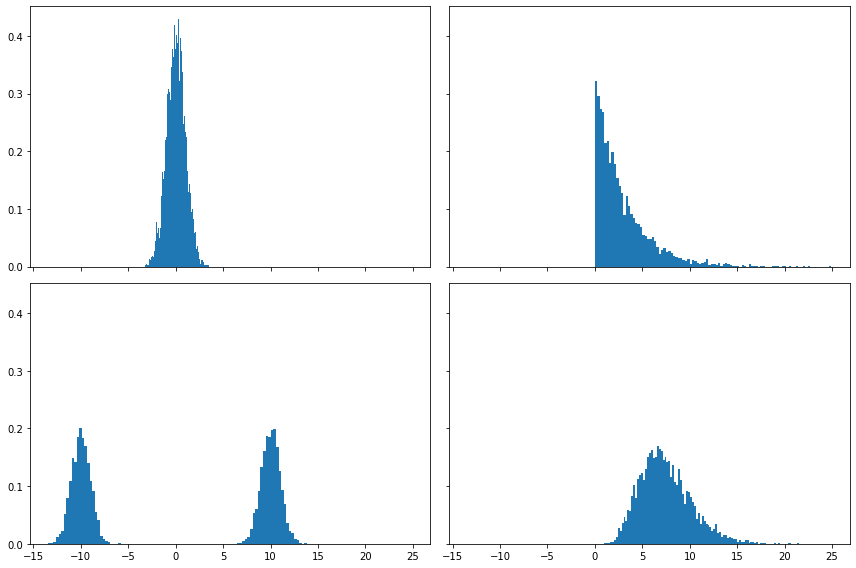

In [4]:
plot_distributions(df_train)

# CatBoost

In [5]:
model = catboost.CatBoostRegressor(
    cat_features=['X1', 'X2'], 
    loss_function="RMSEWithUncertainty",
    num_trees=100
)

In [6]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

0:	learn: 3.2057197	test: 3.2267591	best: 3.2267591 (0)	total: 60.6ms	remaining: 6s
1:	learn: 3.1742412	test: 3.1938513	best: 3.1938513 (1)	total: 63.6ms	remaining: 3.12s
2:	learn: 3.1472661	test: 3.1657448	best: 3.1657448 (2)	total: 66.2ms	remaining: 2.14s
3:	learn: 3.1234309	test: 3.1409927	best: 3.1409927 (3)	total: 69.7ms	remaining: 1.67s
4:	learn: 3.1018779	test: 3.1186829	best: 3.1186829 (4)	total: 72.7ms	remaining: 1.38s
5:	learn: 3.0820421	test: 3.0982137	best: 3.0982137 (5)	total: 75.1ms	remaining: 1.18s
6:	learn: 3.0635381	test: 3.0791736	best: 3.0791736 (6)	total: 77.8ms	remaining: 1.03s
7:	learn: 3.0460951	test: 3.0612728	best: 3.0612728 (7)	total: 79.8ms	remaining: 918ms
8:	learn: 3.0295181	test: 3.0443022	best: 3.0443022 (8)	total: 82.3ms	remaining: 833ms
9:	learn: 3.0136638	test: 3.0281076	best: 3.0281076 (9)	total: 85.2ms	remaining: 767ms
10:	learn: 2.9984250	test: 3.0125736	best: 3.0125736 (10)	total: 88.5ms	remaining: 716ms
11:	learn: 2.9837205	test: 2.9976121	best: 2

In [7]:
calculate_nll_catboost(model, x_train, y_train)

2.518622562346859

In [8]:
calculate_nll_catboost(model, x_test, y_test)

2.522494429980034

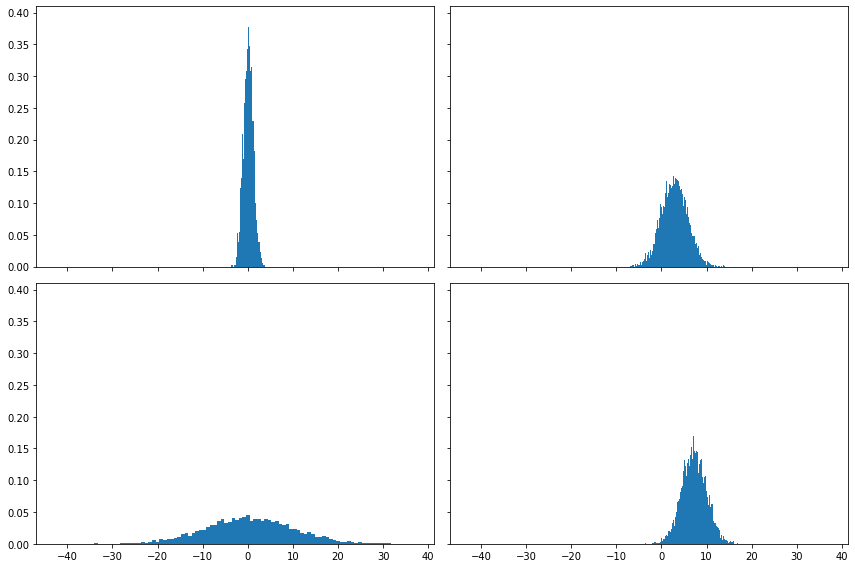

In [9]:
catboost_samples = x_test.copy()
pred = model.predict(x_test)
catboost_samples['value'] = [stats.norm.rvs(loc = pred[i, 0], scale = np.sqrt(pred[i, 1])) for i in range(len(pred))]

plot_distributions(catboost_samples)

# TreeFlow

In [10]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 1], 
    loss_function="RMSEWithUncertainty",
    depth=2,
    num_trees=100,
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(50, 10), 
                                 num_blocks=2, context_dim=50, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=50)

In [11]:
treeflow.fit(x_train.values, y_train.values, x_val.values, y_val.values, n_epochs=50, batch_size=1024, verbose=True)

0:	learn: 3.2057197	total: 2.38ms	remaining: 235ms
1:	learn: 3.1742412	total: 4.04ms	remaining: 198ms
2:	learn: 3.1472661	total: 5.61ms	remaining: 181ms
3:	learn: 3.1234309	total: 7.15ms	remaining: 172ms
4:	learn: 3.1018779	total: 8.67ms	remaining: 165ms
5:	learn: 3.0820421	total: 10.9ms	remaining: 170ms
6:	learn: 3.0635381	total: 14.9ms	remaining: 198ms
7:	learn: 3.0460951	total: 18.5ms	remaining: 213ms
8:	learn: 3.0295181	total: 23.1ms	remaining: 234ms
9:	learn: 3.0136638	total: 26.8ms	remaining: 241ms
10:	learn: 2.9984250	total: 28.7ms	remaining: 232ms
11:	learn: 2.9837205	total: 30.8ms	remaining: 226ms
12:	learn: 2.9694877	total: 33.3ms	remaining: 223ms
13:	learn: 2.9556778	total: 36.3ms	remaining: 223ms
14:	learn: 2.9422526	total: 39.6ms	remaining: 225ms
15:	learn: 2.9291814	total: 41.6ms	remaining: 218ms
16:	learn: 2.9164399	total: 45.4ms	remaining: 222ms
17:	learn: 2.9040079	total: 49.2ms	remaining: 224ms
18:	learn: 2.8918694	total: 71.1ms	remaining: 303ms
19:	learn: 2.8800108	t

RuntimeError: 

In [ ]:
calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

In [ ]:
calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

In [ ]:
treeflow_samples = x_test.copy()
treeflow_samples['value'] = treeflow.sample(treeflow_samples.values, num_samples=1).squeeze()

plot_distributions(treeflow_samples)

## Comparison plot

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 8))


dataframe = df_test

sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'X'), 'value'], ax=axes[0][0], color='red', label='True dist.')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'Y'), 'value'], ax=axes[0][1], color='red', label='True dist.')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'X'), 'value'], ax=axes[1][0], color='red', label='True dist.')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'Y'), 'value'], ax=axes[1][1], color='red', label='True dist.')


dataframe = catboost_samples

sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'X'), 'value'], ax=axes[0][0], color='orange', label='CatBoost')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'Y'), 'value'], ax=axes[0][1], color='orange', label='CatBoost')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'X'), 'value'], ax=axes[1][0], color='orange', label='CatBoost')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'Y'), 'value'], ax=axes[1][1], color='orange', label='CatBoost')


dataframe = treeflow_samples

sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'X'), 'value'], ax=axes[0][0], color='blue', label='TreeFlow')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'Y'), 'value'], ax=axes[0][1], color='blue', label='TreeFlow')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'X'), 'value'], ax=axes[1][0], color='blue', label='TreeFlow')
sns.kdeplot(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'Y'), 'value'], ax=axes[1][1], color='blue', label='TreeFlow')

plt.tight_layout()
plt.legend()
plt.xlim(-20, 20)